In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.fftpack import fft
from IPython.display import display

import pywt
import scipy.stats

import datetime as dt
from collections import defaultdict, Counter

from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Usuario\.conda\envs\SistDin\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  me

In [2]:
def calculate_entropy(datoX):
    counter_values = Counter(datoX).most_common()
    probabilities = [elem[1]/len(datoX) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(datoX):
    n5 = np.nanpercentile(datoX, 5)
    n25 = np.nanpercentile(datoX, 25)
    n75 = np.nanpercentile(datoX, 75)
    n95 = np.nanpercentile(datoX, 95)
    median = np.nanpercentile(datoX, 50)
    mean = np.nanmean(datoX)
    std = np.nanstd(datoX)
    var = np.nanvar(datoX)
    rms = np.nanmean(np.sqrt(datoX**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(datoX):
    zero_crossing_indices = np.nonzero(np.diff(np.array(datoX) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(datoX) > np.nanmean(datoX)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(datoX):
    entropy = calculate_entropy(datoX)
    crossings = calculate_crossings(datoX)
    statistics = calculate_statistics(datoX)
    return [entropy] + crossings + statistics

def get_uci_har_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y

def get_train_test(df, y_col, x_cols, ratio):
    """ 
    This method transforms a dataframe into a train and test set, for this you need to specify:
    1. the ratio train : test (usually 0.7)
    2. the column with the Y_values
    """
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
       
    Y_train = df_train[y_col].values
    Y_test = df_test[y_col].values
    X_train = df_train[x_cols].values
    X_test = df_test[x_cols].values
    return df_train, df_test, X_train, Y_train, X_test, Y_test

# Ayuda diagnóstica desde el ECG

![figuras/ECGdagrama.png](figuras/ECGdagrama.png)

## Carga de los datos

Los datos están disponibles en [https://github.com/mathworks/physionet_ECG_data/blob/master/ECGData.zip](https://github.com/mathworks/physionet_ECG_data/blob/master/ECGData.zip).

El archivo corresponde a un workspace de Matlab, por lo que debe importarse.

In [3]:
filename = './datos/ECGData.mat'
ecg_data = sio.loadmat(filename)
ecg_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Dec 15 11:26:17 2017',
 '__version__': '1.0',
 '__globals__': [],
 'ECGData': array([[(array([[-0.0978573 , -0.15688126, -0.13781616, ..., -0.07490498,
                 -0.11652732, -0.18042101],
                [ 0.1193611 ,  0.18755853,  0.16956925, ..., -0.09721826,
                 -0.12393573, -0.10648055],
                [-0.02460175, -0.03627935, -0.0359677 , ..., -0.18614223,
                 -0.12998497, -0.12235631],
                ...,
                [-0.355     , -0.355     , -0.345     , ..., -0.335     ,
                 -0.315     , -0.315     ],
                [-0.275     , -0.245     , -0.285     , ..., -0.205     ,
                 -0.145     , -0.165     ],
                [ 0.125     ,  0.005     ,  0.025     , ..., -0.225     ,
                 -0.275     , -0.205     ]]), array([[array(['ARR'], dtype='<U3')],
                [array(['ARR'], dtype='<U3')],
                [array(['ARR'], d

In [4]:
ecg_signals = ecg_data['ECGData'][0][0][0]
ecg_signals

array([[-0.0978573 , -0.15688126, -0.13781616, ..., -0.07490498,
        -0.11652732, -0.18042101],
       [ 0.1193611 ,  0.18755853,  0.16956925, ..., -0.09721826,
        -0.12393573, -0.10648055],
       [-0.02460175, -0.03627935, -0.0359677 , ..., -0.18614223,
        -0.12998497, -0.12235631],
       ...,
       [-0.355     , -0.355     , -0.345     , ..., -0.335     ,
        -0.315     , -0.315     ],
       [-0.275     , -0.245     , -0.285     , ..., -0.205     ,
        -0.145     , -0.165     ],
       [ 0.125     ,  0.005     ,  0.025     , ..., -0.225     ,
        -0.275     , -0.205     ]])

In [5]:
ecg_labels_ = ecg_data['ECGData'][0][0][1]
ecg_labels_

array([[array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [array(['ARR'], dtype='<U3')],
       [arra

In [6]:
ecg_labels = list(map(lambda x: x[0][0], ecg_labels_))
ecg_labels

['ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'ARR',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',
 'CHF',


In [7]:

dict_ecg_data = defaultdict(list)
for ii, label in enumerate(ecg_labels):
    dict_ecg_data[label].append(ecg_signals[ii])
dict_ecg_data

defaultdict(list,
            {'ARR': [array([-0.0978573 , -0.15688126, -0.13781616, ..., -0.07490498,
                     -0.11652732, -0.18042101]),
              array([ 0.1193611 ,  0.18755853,  0.16956925, ..., -0.09721826,
                     -0.12393573, -0.10648055]),
              array([-0.02460175, -0.03627935, -0.0359677 , ..., -0.18614223,
                     -0.12998497, -0.12235631]),
              array([-0.50830948, -0.80800908, -0.72168411, ..., -1.04269618,
                     -1.04068357, -1.04819182]),
              array([-0.31203941, -0.49525996, -0.44259662, ...,  0.82249412,
                      0.78723928,  0.68429342]),
              array([-0.03139103, -0.04704876, -0.04569938, ..., -0.2463429 ,
                     -0.61526174, -0.61654212]),
              array([-0.39269434, -0.62558106, -0.55611118, ..., -0.68287496,
                     -0.65005254, -0.64884771]),
              array([-0.22679873, -0.32728147, -0.3407746 , ..., -1.17924701,
        

Se tienen datos de las siguientes clases:
- Normal Sinus Rhythm (NSR) 
- Abnormal Arrhythmia (ARR) 
- Congestive Heart Failure (CHF)

**Ejemplos de los ECG**

(30000, 31000)

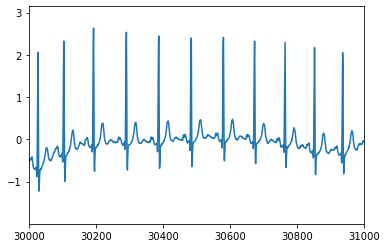

In [8]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['NSR'][4])
plt.xlim([30000,31000])

(30000, 31000)

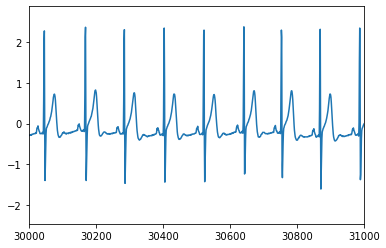

In [9]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['NSR'][7])
plt.xlim([30000,31000])

(30000, 31000)

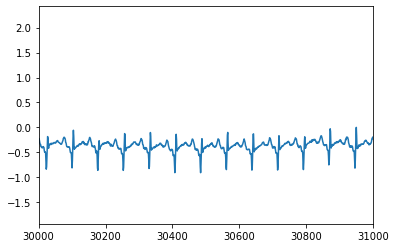

In [10]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['CHF'][4])
plt.xlim([30000,31000])

(30000, 31000)

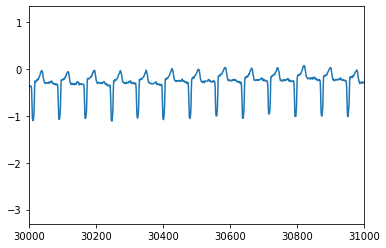

In [11]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['CHF'][8])
plt.xlim([30000,31000])

(30000, 31000)

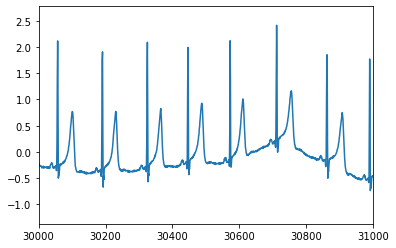

In [12]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['ARR'][4])
plt.xlim([30000,31000])

(30000, 31000)

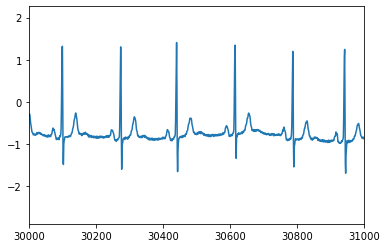

In [13]:
fig, ax = plt.subplots()
ax.plot(dict_ecg_data['ARR'][14])
plt.xlim([30000,31000])

## Extracción de características

Basada en la transformada wavelet con el kernal 'sym5'

Los coeficientes wavelet se calculan con:

$$W T_\psi (a,b) \{ x\} = \int x(t) \psi_{a,b}(t)dt$$

para la escala $a$ y el desplazamiento $b$. Con ECG suele ser util el kernel sym5.
![figuras/sym5.png](figuras/sym5.png)

Observe que el efecto del desplazamiento permite recuperar en qué instante ocurre un evento en cada señal. El efecto de la escala permite recuperar las frecuencias momentaneas presentes.

![figuras/WaveletEscalaDesplazamiento.png](figuras/WaveletEscalaDesplazamiento.png)




En la metodología propuesta, se busca sacar algunos estadísticos a partir de los coeficientes de Wavelet.

NameError: name 'data' is not defined

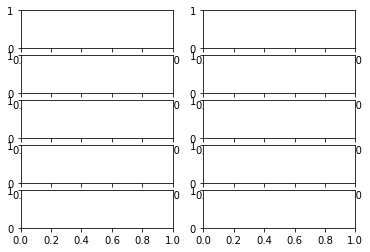

In [14]:


fig, axarr = plt.subplots(nrows=5, ncols=2)
axarr[0,0].plot(data, 'r')
axarr[1, 1].plot(coeff_d[1], 'g')

In [ ]:
def graf_w(data):
    coeff_d = pywt.wavedec(data, 'sym5')
    fig, axarr = plt.subplots(nrows=5, ncols=2)
    axarr[0, 0].plot(data)
    axarr[0, 1].plot(coeff_d[0])
    axarr[1, 1].plot(coeff_d[1])
    axarr[2, 1].plot(coeff_d[2])
    axarr[3, 1].plot(coeff_d[3])
    axarr[4, 1].plot(coeff_d[4])

In [ ]:
graf_w(dict_ecg_data['NSR'][4])


In [ ]:
graf_w(dict_ecg_data['NSR'][7])

In [ ]:
list_labels = []
list_features = []#
for k, v in dict_ecg_data.items():# para cada clase
    yval = list(dict_ecg_data.keys()).index(k) # la señal capturada en la prueba k
    
    for signal in v: # para cada señal en la clase
        
        features = []
        list_labels.append(yval)
        list_coeff = pywt.wavedec(signal, 'sym5')
        for coeff in list_coeff:
            features += get_features(coeff)
        list_features.append(features)
df = pd.DataFrame(list_features)
ycol = 'y'
xcols = list(range(df.shape[1]))
df.loc[:,ycol] = list_labels

In [ ]:
list_coeff

In [ ]:
list_features

In [ ]:
df

## Separa aleatoriamente para train y test

In [ ]:
df_train, df_test, X_train, Y_train, X_test, Y_test = get_train_test(df, ycol, xcols, ratio = 0.7)

In [ ]:
dict_ecg_data.keys()

- Datos en el conjunto de datos completo por cada clase

In [ ]:
y0=sum(df.y==0)
y1=sum(df.y==1)
y2=sum(df.y==2)
sns.barplot(x=['ARR','CHF','NSR'],y=[y0,y1,y2])

- Datos en el conjunto de datos de entrenamiento por cada clase

In [ ]:
y0=sum(df_train.y==0)
y1=sum(df_train.y==1)
y2=sum(df_train.y==2)
sns.barplot(x=['ARR','CHF','NSR'],y=[y0,y1,y2])

Entrena el clasificador

In [ ]:
cls = GradientBoostingClassifier(n_estimators=10000)
cls.fit(X_train, Y_train)
train_score = cls.score(X_train, Y_train)
test_score = cls.score(X_test, Y_test)


In [ ]:
print("The Train Score is {}".format(train_score))

print("The Test Score is {}".format(test_score))

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred = cls.predict(X_test)
confusion_matrix(Y_test, Y_pred, labels=['ARR','CHF','NSR'])

In [ ]:
Y_test

In [ ]:
Y_pred

In [ ]:
confusion_matrix(Y_test, Y_pred)

In [ ]:
Y_pred

In [ ]:
Y_test

In [ ]:
confusion_matrix()